In [ ]:
# 1.Imporation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# 3. Chargement des données
df = pd.read_csv('train_test_data.csv')

In [ ]:
# 4. Visualisation de la Dataset
print("Sample of the Dataset:")
print(df.head())

Sample of the Dataset:
                  Date   Id_compte  amount_transaction  \
0  2022-01-01 00:23:00   SEWC_CL.1              462.96   
1  2022-01-01 00:26:00  SEW0C_LI.1               15.51   
2  2022-01-01 01:01:00        US.1                2.24   
3  2022-01-01 01:21:00        TA.1                2.86   
4  2022-01-01 01:54:00        US.1                1.68   

                           category_transaction  
0                      Food & Drink - Groceries  
1  General Services - Home Repair + Maintenance  
2              Bank Transfers - ATM withdrawals  
3             Transportation - Public Transport  
4              Bank Transfers - ATM withdrawals  


In [ ]:
# 3. Vérification des données manquantes
missing_data = df.isnull().sum()
print("\nMissing Data:")
print(missing_data)


Missing Data:
Date                    0
Id_compte               0
amount_transaction      0
category_transaction    0
dtype: int64


In [ ]:
# 4. Exploration et visualisation des données actuelles, des tendances et de la saisonnalité
def explore_and_visualize_data(df,specified_account_id):
    decomposition = seasonal_decompose(account_data['amount_transaction'], period=7)
    # Visualize daily transaction amount over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Day', y='amount_transaction', data=account_data, label='Daily Transaction Amount')
    plt.title(f'Daily Transaction Amount for {specified_account_id}')
    plt.xlabel('Date')
    plt.ylabel('Transaction Amount')
    plt.show()


    # Visualize decomposition components
    plt.figure(figsize=(12, 8))
    components = ['observed', 'trend', 'seasonal', 'resid']  # Updated attribute names
    for i, component in enumerate(components):
        plt.subplot(4, 1, i + 1)
        plt.plot(account_data['Day'], getattr(decomposition, component), label=component.capitalize())
        plt.legend(loc='upper left')
        plt.xlabel('Date')
        plt.ylabel(component.capitalize())

    plt.tight_layout()
    plt.show()





In [ ]:
# Function to handle negative values
def replace_negatives_with_zero(arr):
    return np.maximum(arr, 0)

In [ ]:
# Function to calculate sMAPE
def calculate_smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

In [ ]:
#Fonction pour produire un dataframe de transactions journalières pour un compte
def preprocess_data(specified_account_id, df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Day'] = df['Date'].dt.floor('d')
  account_data = df[df['Id_compte'] == specified_account_id]
  daily_totals = account_data.groupby('Day')['amount_transaction'].sum().reset_index()
  return daily_totals



In [ ]:
# 6. Construction du modèle et entraînement
def train_model(specified_account_id, df):
    account_data = df[df['Id_compte'] == specified_account_id]

    daily_totals = account_data.groupby('Day')['amount_transaction'].sum().reset_index()

    if len(daily_totals) < 2:
        raise ValueError(f"Not enough data points for training and testing for account {specified_account_id}.")

    train, test = train_test_split(daily_totals, test_size=0.2, shuffle=False)
    train_series = train['amount_transaction']
    test_series = test['amount_transaction']

    # Reduce the range of parameters
    p = q = d = range(0, 2)
    pdq = list(product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(product(p, d, q))]

    best_smape = np.inf
    best_order = None
    best_seasonal_order = None

    for order in pdq:
        for seasonal_order in seasonal_pdq:
            try:
                model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order,
                                enforce_stationarity=False, enforce_invertibility=False)
                fit_model = model.fit()


                # Calculate sMAPE for the current parameters
                y_future = fit_model.get_forecast(steps=len(test_series)).predicted_mean
                y_future_non_negative = replace_negatives_with_zero(y_future)
                smape_current = calculate_smape(test_series, y_future_non_negative)

                if smape_current < best_smape:
                    best_smape = smape_current
                    best_order = order
                    best_seasonal_order = seasonal_order

            except Exception as e:
                print(f"Error: Unable to fit the model for account {specified_account_id} with order {order} and "


                      f"seasonal order {seasonal_order}. Error: {e}")
                continue

    print(f"Best parameters for {specified_account_id}: Order {best_order}, Seasonal Order {best_seasonal_order}, sMAPE: {best_smape}")

    # Return the best parameters
    return best_order, best_seasonal_order



In [ ]:
#Prédiction future
def predict_future(specified_account_id, df, prediction_start_date, prediction_end_date, best_order, best_seasonal_order):
    try:
        account_data = df[df['Id_compte'] == specified_account_id]

        # Include lag features in the feature set
        account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
        account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)

        daily_totals = account_data.groupby('Day')[['amount_transaction', 'amount_transaction_lag_1', 'amount_transaction_lag_2']].sum().reset_index()

        if len(daily_totals) < 2:
            raise ValueError(f"Not enough data points for training and testing for account {specified_account_id}.")

        train, test = train_test_split(daily_totals, test_size=0.2, shuffle=False)
        train_series = train['amount_transaction']

        # Include lag features in the training set
        train_features = train[['amount_transaction_lag_1', 'amount_transaction_lag_2']]

        model = SARIMAX(train_series, exog=train_features, order=best_order, seasonal_order=best_seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        fit_model = model.fit()

        # Predict on future dates with the best parameters
        future_dates = pd.date_range(start=prediction_start_date, end=prediction_end_date, freq='D')
        X_future = pd.DataFrame({'Day': future_dates})
        X_future['amount_transaction'] = 0

        for lag in range(1, 3):
            X_future[f'amount_transaction_lag_{lag}'] = X_future['amount_transaction'].shift(lag)

        # Drop rows with missing or infinite values
        X_future = X_future.replace([np.inf, -np.inf], np.nan).dropna()

        # Include lag features in the future predictions
        future_features = X_future[['amount_transaction_lag_1', 'amount_transaction_lag_2']]
        y_future = fit_model.get_forecast(steps=len(X_future), exog=future_features).predicted_mean
        y_future_non_negative = replace_negatives_with_zero(y_future)

        # Save the predictions to a CSV file
        prediction_dates = pd.date_range(start=prediction_start_date, periods=len(y_future_non_negative))
        results_df = pd.DataFrame({
            'ID': prediction_dates.astype(str) + '_' + specified_account_id,
            'Predicted_Amount': y_future_non_negative.values
        })

        output_file_name = specified_account_id + '_future_predictions.csv'
        results_df.to_csv(output_file_name, index=False)


    except Exception as e:
        print(f"Error predicting future for account {specified_account_id}. Error: {e}")



In [ ]:
# Main loop for each account
account_ids = df['Id_compte'].unique()

for account_id in account_ids:
    #Data Processing
    account_data = preprocess_data(account_id, df)
    # Formation du modèle et obtention des meilleurs paramètres
    best_order, best_seasonal_order = train_model(account_id, df)
    predict_future(account_id, df, '2022-11-08', '2023-01-12', best_order, best_seasonal_order)




/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best parameters for SEWC_CL.1: Order (1, 0, 1), Seasonal Order (1, 1, 0, 3), sMAPE: 94.55069519794291


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for SEW0C_LI.1: Order (1, 1, 1), Seasonal Order (0, 0, 1, 3), sMAPE: 103.61670075758711


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)


Best parameters for US.1: Order (0, 1, 0), Seasonal Order (0, 0, 0, 3), sMAPE: 94.79916352324068


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for TA.1: Order (0, 1, 0), Seasonal Order (1, 1, 1, 3), sMAPE: 91.69402178461752


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for HP.1: Order (0, 1, 0), Seasonal Order (0, 1, 1, 3), sMAPE: 91.36591202685756


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for CPA_MP.1: Order (1, 1, 0), Seasonal Order (0, 0, 0, 3), sMAPE: 87.99071864932174


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)


Best parameters for SEW0C_HI.1: Order (0, 1, 0), Seasonal Order (0, 0, 0, 3), sMAPE: 104.78390499157683


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for IPA.1: Order (0, 1, 0), Seasonal Order (0, 0, 1, 3), sMAPE: 101.4111313968112


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for CPA.1: Order (0, 0, 0), Seasonal Order (1, 1, 0, 3), sMAPE: 103.08133057381481


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)


Best parameters for SEWC_P_PL.1: Order (1, 0, 1), Seasonal Order (1, 0, 0, 3), sMAPE: 85.30120936277585


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for SEWC_PA.1: Order (0, 1, 1), Seasonal Order (0, 1, 1, 3), sMAPE: 72.19537379759808


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Best parameters for SEWC_P.1: Order (1, 1, 0), Seasonal Order (1, 0, 1, 3), sMAPE: 94.55229562218676


<ipython-input-177-a309c801b313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_1'] = account_data['amount_transaction'].shift(1)
<ipython-input-177-a309c801b313>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_data['amount_transaction_lag_2'] = account_data['amount_transaction'].shift(2)


In [ ]:
#Concaténation de l'ensemble des fichiers pour avoir le fichier à envoyer "Final.csv"
import pandas as pd
import os

# Specify the directory where your CSV files are located
directory = '/content/fin'
# List to hold DataFrames from each file
dataframes = []

# Iterate through files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Interleave rows from different files
concatenated_data = pd.concat(dataframes, ignore_index=True)

# Sort the DataFrame based on the 'ID' column
concatenated_data.sort_values(by='ID', inplace=True)


# Rename the second column to a new name (replace 'old_name' and 'new_name' with your actual names)
concatenated_data = concatenated_data.rename(columns={'Predicted_amount': 'Predicted_Amount'})
conca=concatenated_data.head(648)
# Save the concatenated DataFrame to a new CSV file
output_file_path = 'FINAL.csv'
conca.to_csv(output_file_path, index=False)

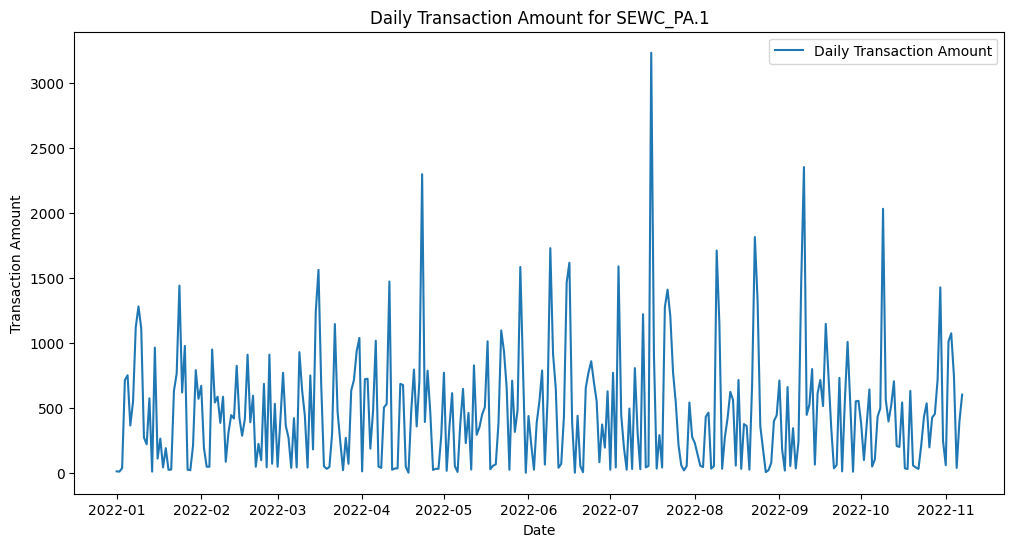

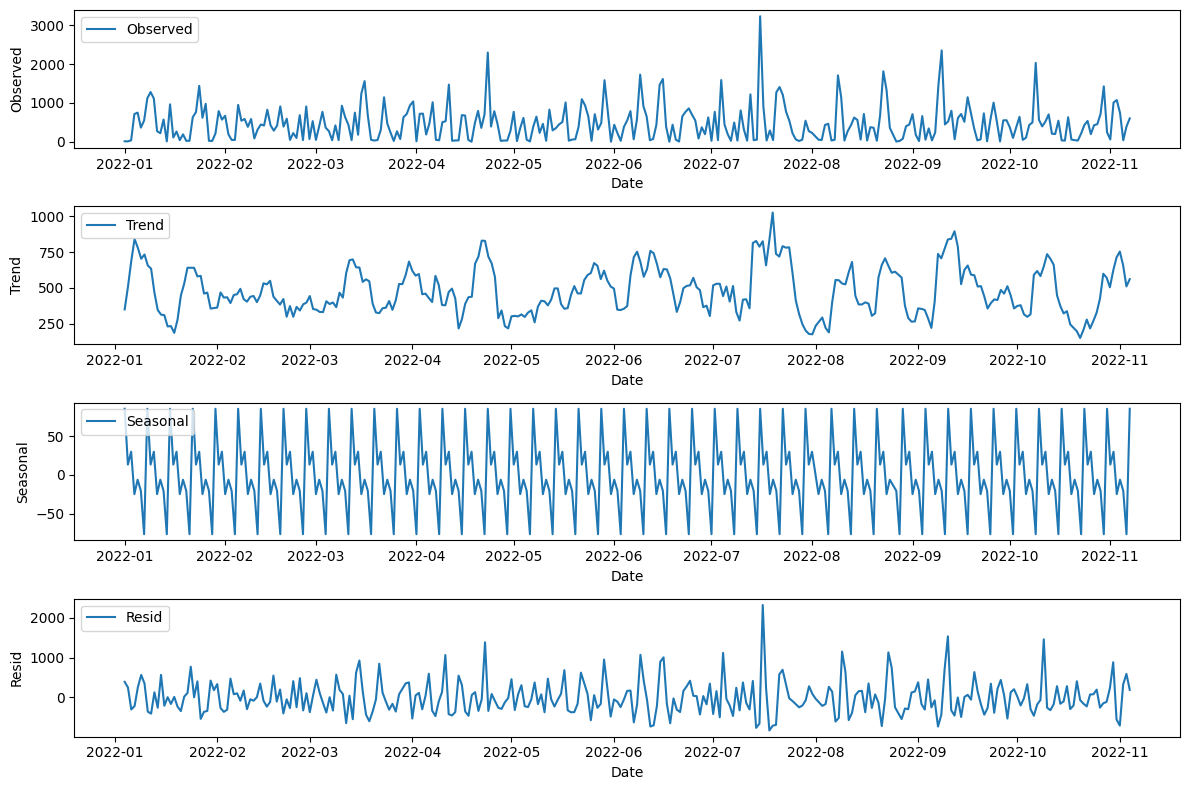

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best parameters for SEWC_PA.1: Order (0, 1, 1), Seasonal Order (0, 1, 1, 3), sMAPE: 72.19537379759808


In [ ]:
#Exemple pour la visualisation de processus pour un compte spécifique

# 1. Chargement des données
df = pd.read_csv('train_test_data.csv')
# 2. Sélection d'un compte spécifique (remplacez account_id avec l'ID du compte souhaité)
account_id = 'SEWC_PA.1'
# 3. Prétraitement des données
account_data = preprocess_data(account_id, df)
# 4. Exploration et visualisation des données
explore_and_visualize_data(account_data,account_id)

# 5. Formation du modèle et obtention des meilleurs paramètres
best_order, best_seasonal_order = train_model(account_id, df)
# 6. Prediction pou la période définie


